In [1]:
import os
import numpy as np
import time as time

# Import torch and select GPU
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB


In [2]:

import ptwt
import math
from quantifai.utils import max_eigenval
from quantifai.empty import Identity

## Start development


In [3]:
class Wavelets_torch(torch.nn.Module):
    """
    Constructs a linear operator for abstract Daubechies Wavelets
    """

    def __init__(self, wav, levels, mode="periodic", shape=None):
        """Initialises Daubechies Wavelet linear operator class

        Args:

            wav (string): Wavelet type (see https://tinyurl.com/5n7wzpmb)
            levels (int): Wavelet levels (scales) to consider
            mode (str): Wavelet signal extension mode
            shape (tuple): image shape

        Raises:

            ValueError: Raised when levels are not positive definite
            ValueError: Raised if the wavelet type is not a string
            ValueError: Raised if wavelet type is `self` and a shape is not provided

        """
        super().__init__()
        if np.any(levels <= 0):
            raise ValueError("'levels' must be positive")
        if not isinstance(wav, str):
            raise ValueError("'wav' must be a string")
        self.wav = wav
        self.levels = np.int64(levels)
        self.mode = mode

        if wav == "self":
            self.shape = shape
            if shape is None:
                raise ValueError("`self` wavelet type requires the shape of the images as input.")

            self.adj_op(self.dir_op(torch.ones(self.shape)))
        else:
            self.adj_op(self.dir_op(torch.ones((1, 64, 64))))

    def dir_op(self, x):
        """Evaluates the forward abstract wavelet transform of x

        Args:

            x (torch.Tensor): Array to wavelet transform. Can be [batch, H, W] or [H, W],
                but it will raise an error if used with [batch, channels, H, W].

        Returns:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Wavelet decomposition coefficients

        Raises:

            ValueError: Raised when the shape of x is not even in every dimension
        """
        if self.wav == "self":
            return torch.ravel(x)
        else:
            if x.dim() >= 4:
                return ptwt.wavedec2(
                    x.squeeze(1), wavelet=self.wav, level=self.levels, mode=self.mode
                )
            else:
                return ptwt.wavedec2(x, wavelet=self.wav, level=self.levels, mode=self.mode)

    def adj_op(self, coeffs):
        """Evaluates the forward adjoint abstract wavelet transform of x

        Args:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Wavelet decomposition coefficients

        Returns:

            img (torch.Tensor): reconstruted image.
        """
        if self.wav == "self":
            return torch.reshape(coeffs, self.shape)
        else:
            return ptwt.waverec2(coeffs, wavelet=self.wav).squeeze(1)



In [4]:
class DictionaryWv_torch(torch.nn.Module):
    """
    Constructs class to permit sparsity averaging across a collection of wavelet dictionaries
    """

    def __init__(self, wavs, levels, mode="periodic", shape=None):
        """Initialises a linear operator for a collection of abstract wavelet dictionaries

        Args:

            wavs (list[string]): List of wavelet types (see https://tinyurl.com/5n7wzpmb)
            levels (list[int]): Wavelet levels (scales) to consider
            mode (str): Wavelet signal extension mode shared by all dictionaries
            shape (tuple): image shape

        Raises:

            ValueError: Raised when levels are not positive definite

        """
        super().__init__()
        self.wavelet_list = []
        self.mode = mode
        self.wavs = wavs
        self.levels = levels
        self.shape = shape
        if np.isscalar(levels):
            self.levels = np.ones(len(self.wavs)) * levels
        for i in range(len(self.wavs)):
            self.wavelet_list.append(
                Wavelets_torch(self.wavs[i], self.levels[i], self.mode, self.shape)
            )

    def dir_op(self, x):
        """Evaluates a list of forward abstract wavelet transforms of x

        Args:

            x (torch.Tensor): Tensor to wavelet transform

        """
        buff = []
        buff.append(self.wavelet_list[0].dir_op(x))
        for wav_i in range(1, len(self.wavelet_list)):
            buff.append(self.wavelet_list[wav_i].dir_op(x))
        return buff

    def adj_op(self, coeffs):
        """Evaluates a list of forward adjoint abstract wavelet transforms of x

        Args:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Coefficients to adjoint wavelet transform

        """
        out = self.wavelet_list[0].adj_op(coeffs[0])
        for wav_i in range(1, len(self.wavelet_list)):
            out = out + self.wavelet_list[wav_i].adj_op(coeffs[wav_i])
        return out / len(self.wavelet_list)
    



In [5]:
class L1Norm_torch(torch.nn.Module):
    """This class computes the proximity operator of the l2 ball.

                        f(x) = ||Psi x||_1 * gamma

    When the input 'x' is an array. gamma is a regularization term. Psi is a sparsity operator.
    """

    def __init__(self, gamma, Psi=None, op_to_coeffs=False):
        """Initialises an l1-norm proximal operator class

        Args:

            gamma (double >= 0): Regularisation parameter
            Psi (Linear operator): Regularisation functional (typically wavelets)

        Raises:

            ValueError: Raised if regularisation parameter is not postitive semi-definite
        """
        super().__init__()
        if np.any(gamma <= 0):
            raise ValueError("'gamma' must be positive semi-definite")

        self.gamma = gamma
        self.beta = 1.0
        self.op_to_coeffs = op_to_coeffs

        if Psi is None:
            self.Psi = Identity()
            self.num_wavs = 0
        else:
            self.Psi = Psi
            # Set the number of wavelets dictionaries
            self.num_wavs = len(self.Psi.wavelet_list)

        if self.op_to_coeffs:
            self.prox = self._prox_coeffs
            self.fun = self._fun_coeffs
        else:
            self.prox = self._prox
            self.fun = self._fun

    def _apply_op_to_coeffs(self, coeffs, op):
        """Applies operation to all coefficients in ptwt structure."""
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):

            if torch.is_tensor(coeffs[wav_i]):
                # case of `self` wavelets
                coeffs[wav_i] = op(coeffs[wav_i])
            else:
                # Apply op over the low freq approx
                coeffs[wav_i][0] = op(coeffs[wav_i][0])
                # Iterate over the wavelet decomp and apply op
                for it1 in range(1, len(coeffs[0])):
                    coeffs[wav_i][it1] = tuple([op(elem) for elem in coeffs[wav_i][it1]])

        return coeffs

    def _op_to_two_coeffs(self, coeffs1, coeffs2, op):
        """Applies operation to two set of coefficients in ptwt structure.

        Saves result in coeffs1.

        Args:

            coeffs1 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                First set of wavelet coefficients
            coeffs2 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Second set of wavelet coefficients
            op (function): Operation to apply

        Returns:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Resulting coefficients
        """
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):

            if torch.is_tensor(coeffs1[wav_i]) or torch.is_tensor(coeffs2[wav_i]):
                # case of `self` wavelets
                coeffs1[wav_i] = op(coeffs1[wav_i], coeffs2[wav_i])
            else:
                # Apply op over the low freq approx
                coeffs1[wav_i][0] = op(coeffs1[wav_i][0], coeffs2[wav_i][0])
                # Iterate over the wavelet decomp and apply op
                for it1 in range(1, len(coeffs1[0])):
                    coeffs1[wav_i][it1] = tuple(
                        [
                            op(elem1, elem2)
                            for elem1, elem2 in zip(
                                coeffs1[wav_i][it1], coeffs2[wav_i][it1]
                            )
                        ]
                    )
        return coeffs1

    def _get_max_abs_coeffs(self, coeffs):
        """Get the max abs value of all coefficients

        Args:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Set of wavelet coefficients

        Returns:

            max abs value of all coefficients
        """
        max_val = []
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):

            if torch.is_tensor(coeffs[wav_i]):
                # case of `self` wavelets
                max_val.append(torch.max(torch.abs(coeffs[wav_i])))
            else:
                # Apply op over the low freq approx
                max_val.append(torch.max(torch.abs((coeffs[wav_i][0]))))
                # Iterate over the wavelet decompositions
                for it1 in range(1, len(coeffs[0])):
                    for it2 in range(len(coeffs[wav_i][it1])):
                        max_val.append(torch.max(torch.abs((coeffs[wav_i][it1][it2]))))

        # Apply operation to the coefficients
        return torch.max(torch.tensor(max_val)).item()

    def _prox_coeffs(self, x, tau):
        """Evaluates the l1-norm prox of Psi x

        Args:

            x (ptwt.coeffs): Array to evaluate proximal projection of
            tau (double): Custom weighting of l1-norm prox

        Returns:

            l1-norm prox of x
        """
        # Define the element-wise operation
        # op = partial(self._prox, tau=tau)
        op = lambda _x: self._prox(_x, tau=tau)
        # Apply operation to the coefficients
        return self._apply_op_to_coeffs(x, op)

    def _fun_coeffs(self, coeffs):
        """Evaluates loss of l1-norm regularisation for coeffs

        Args:

            x (ptwt.coeffs): Array to evaluate proximal projection of
            tau (double): Custom weighting of l1-norm prox

        Returns:

            l1-norm prox of x
        """
        loss = 0
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):

            if torch.is_tensor(coeffs[wav_i]):
                # case of `self` wavelets
                loss += self._fun(coeffs[wav_i])
            else:
                # Apply op over the low freq approx
                loss += self._fun(coeffs[wav_i][0])
                # Iterate over the wavelet decompositions
                for it1 in range(1, len(coeffs[0])):
                    for it2 in range(len(coeffs[wav_i][it1])):
                        loss += self._fun(coeffs[wav_i][it1][it2])

        # Apply operation to the coefficients
        return loss

    def _prox(self, x, tau):
        """Evaluates the l1-norm prox of x.

        Args:

            x (torch.Tensor): Array to evaluate proximal projection of
            tau (double): Custom weighting of l1-norm prox

        Returns:

            l1-norm prox of x
        """
        # Replaced the use of torch.sign() to add complex value support
        abs_x = torch.abs(x)
        return torch.maximum(
            torch.zeros_like(abs_x), abs_x - self.gamma * tau
        ) * torch.nan_to_num(x / abs_x, nan=0.0)

        # return torch.maximum(
        #         torch.zeros_like(x), torch.abs(x) - self.gamma * tau
        #     ) * torch.exp(
        #         torch.complex(torch.tensor(0.), torch.tensor(1.)) * torch.angle(x)
        #     )

    def _fun(self, x):
        """Evaluates loss of functional term of l1-norm regularisation

        Args:

            x (torch.Tensor): Tensor to evaluate loss of

        Returns:

            l1-norm loss
        """
        return torch.sum(torch.abs(self.gamma * x))

    def dir_op(self, x):
        """Evaluates the forward regularisation operator

        Args:

            x (torch.Tensor): Tensor to forward transform

        Returns:

            Forward regularisation operator applied to x
        """
        return self.Psi.dir_op(x)

    def adj_op(self, x):
        """Evaluates the forward adjoint regularisation operator

        Args:

            x (torch.Tensor): Tensor to adjoint transform

        Returns:

            Forward adjoint regularisation operator applied to x
        """
        return self.Psi.adj_op(x)


In [6]:
class Operation2WaveletCoeffs_torch(torch.nn.Module):
    """This class helps to apply operations to wavelet coefficients."""

    def __init__(self, Psi=None):
        """Initialise

        Args:
            Psi (Linear operator): Wavelet transform class


        """
        super().__init__()

        if Psi is None:
            self.Psi = Identity()
            self.levels = 0
            self.num_wavs = 0
        else:
            self.Psi = Psi
            if type(self.Psi) is Wavelets_torch:
                # Number of wavelets used in the dictionary
                self.num_wavs = 1

            elif type(self.Psi) is DictionaryWv_torch:
                # Number of wavelets used in the dictionary
                self.num_wavs = len(self.Psi.wavelet_list)

            # Set the number of wavelets scales
            self.levels = self.Psi.levels

    def _apply_op_to_coeffs(self, coeffs, op):
        """Applies operation to all coefficients in ptwt structure."""
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):

            if torch.is_tensor(coeffs[wav_i]):
                # case of `self` wavelets
                coeffs[wav_i] = op(coeffs[wav_i])
            else:
                # Apply op over the low freq approx
                coeffs[wav_i][0] = op(coeffs[wav_i][0])
                # Iterate over the wavelet decomp and apply op
                for it1 in range(1, len(coeffs[0])):
                    coeffs[wav_i][it1] = tuple([op(elem) for elem in coeffs[wav_i][it1]])

        return coeffs

    def _apply_op_to_coeffs_at_level(self, coeffs, level, op):
        """Applies operation to all coefficients at a given level in ptwt structure.

        level (int or None): Level of wavelet decomposition to apply the operation.
            If the level is None, the operation is applied to all existing levels.
        """
        if level is None:
            coeffs = self._apply_op_to_coeffs(coeffs, op)
        else:
            # Iterate over the wavelet dictionaries
            for wav_i in range(self.num_wavs):
                if torch.is_tensor(coeffs[wav_i]):
                    # case of `self` wavelets
                    # `self` wavelets do not have levels
                    coeffs[wav_i] = op(coeffs[wav_i])
                else:
                    if level == 0:
                        # Apply op over the low freq approx
                        coeffs[wav_i][0] = op(coeffs[wav_i][0])
                    elif level > 0 and level <= len(coeffs[0]):
                        # Apply op to specific level
                        coeffs[wav_i][level] = tuple(
                            [op(elem) for elem in coeffs[wav_i][level]]
                        )
                    else:
                        raise ValueError(
                            "The level requested is higher than the one used in the wavelet decomposition."
                        )

        return coeffs

    def _op_to_two_coeffs(self, coeffs1, coeffs2, op):
        """Applies operation to two set of coefficients in ptwt structure.

        Saves result in coeffs1.

        Args:

            coeffs1 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                First set of wavelet coefficients
            coeffs2 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Second set of wavelet coefficients
            op (function): Operation to apply

        Returns:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Resulting coefficients
        """
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):

            if torch.is_tensor(coeffs1[wav_i]) or torch.is_tensor(coeffs2[wav_i]):
                # case of `self` wavelets
                coeffs1[wav_i] = op(coeffs1[wav_i], coeffs2[wav_i])
            else:
                # Apply op over the low freq approx
                coeffs1[wav_i][0] = op(coeffs1[wav_i][0], coeffs2[wav_i][0])
                # Iterate over the wavelet decomp and apply op
                for it1 in range(1, len(coeffs1[0])):
                    coeffs1[wav_i][it1] = tuple(
                        [
                            op(elem1, elem2)
                            for elem1, elem2 in zip(
                                coeffs1[wav_i][it1], coeffs2[wav_i][it1]
                            )
                        ]
                    )
        return coeffs1

    def _op_to_two_coeffs_at_level(self, coeffs1, coeffs2, level, op):
        """Applies operation to two set of coefficients in ptwt structure at a certain level.

        Saves result in coeffs1.

        Args:

            coeffs1 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                First set of wavelet coefficients
            coeffs2 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Second set of wavelet coefficients
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.
            op (function): Operation to apply

        Returns:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Resulting coefficients
        """
        if level is None:
            coeffs1 = self._op_to_two_coeffs(coeffs1, coeffs2, op)
        else:
            # Iterate over the wavelet dictionaries
            for wav_i in range(self.num_wavs):

                if torch.is_tensor(coeffs1[wav_i]) or torch.is_tensor(coeffs2[wav_i]):
                    # case of `self` wavelets
                    coeffs1[wav_i] = op(coeffs1[wav_i], coeffs2[wav_i])
                else:
                    if level == 0:
                        # Apply op over the low freq approx
                        coeffs1[wav_i][0] = op(coeffs1[wav_i][0], coeffs2[wav_i][0])
                    elif level > 0 and level <= len(coeffs1[0]):
                        # Apply op to specific level
                        coeffs1[wav_i][level] = tuple(
                            [
                                op(elem1, elem2)
                                for elem1, elem2 in zip(
                                    coeffs1[wav_i][level], coeffs2[wav_i][level]
                                )
                            ]
                        )

        return coeffs1

    def _get_max_abs_coeffs(self, coeffs):
        """Get the max abs value of all coefficients

        Args:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Set of wavelet coefficients

        Returns:

            max abs value of all coefficients
        """
        max_val = []
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):

            if torch.is_tensor(coeffs[wav_i]):
                # case of `self` wavelets
                max_val.append(torch.max(torch.abs(coeffs[wav_i])))
            else:
                # Apply op over the low freq approx
                max_val.append(torch.max(torch.abs((coeffs[wav_i][0]))))
                # Iterate over the wavelet decompositions
                for it1 in range(1, len(coeffs[0])):
                    for it2 in range(len(coeffs[wav_i][it1])):
                        max_val.append(torch.max(torch.abs((coeffs[wav_i][it1][it2]))))

        # Apply operation to the coefficients
        return torch.max(torch.tensor(max_val)).item()

    def threshold_coeffs(self, coeffs, thresh, thresh_type, level=None):
        """Threshold coefficients and put to zero

        Args:

            coeffs (ptwt.coeffs): Wavelet coefficients
            thresh (double): Threshold
            thresh_type (str): type of thresholding. Options are: 'soft' or 'hard'.
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Thresholded coefficients (ptwt.coeffs)
        """
        # Define the element-wise operation
        if thresh_type == "soft":
            op = lambda _x: self._threshold_soft(_x, thresh=thresh)
        elif thresh_type == "hard":
            op = lambda _x: self._threshold_hard(_x, thresh=thresh)
        # Apply operation to the coefficients
        return self._apply_op_to_coeffs_at_level(coeffs, level, op)

    def full_op_two_img(self, img1, img2, op, level=None):
        """Apply op to two image wavelet coefficients

        Args:

            img1 (torch.Tensor): Image n1 [H,W]
            img2 (torch.Tensor): Image n2 [H,W]
            op (function): Operation to apply
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Modified img (torch.Tensor)
        """
        return self.adj_op(
            self._op_to_two_coeffs_at_level(
                self.dir_op(img1), self.dir_op(img2), level=level, op=op
            )
        ).squeeze()

    def full_op_threshold_img(self, img, thresh, level=None, thresh_type="soft"):
        """Threshold image wavelet coefficients

        Args:

            img (torch.Tensor): Image [H,W]
            thresh (double): Threshold
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.
            thresh_type (str): type of thresholding. Options are: 'soft' or 'hard'.

        Returns:

            Thresholded img (torch.Tensor)
        """
        return self.adj_op(
            self.threshold_coeffs(
                self.dir_op(img), thresh=thresh, thresh_type=thresh_type, level=level
            )
        ).squeeze()

    def full_op_add_img(self, img, val, level=None):
        """Add val to image wavelet coefficients at given level

        Args:

            img (torch.Tensor): Image [H,W]
            thresh (double): Threshold
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Modified img (torch.Tensor)
        """
        return self.adj_op(
            self.add_value_at_level(self.dir_op(img), level=level, val=val)
        ).squeeze()

    def full_op_mult_img(self, img, val, level=None):
        """Multiply val to image wavelet coefficients at given level

        Args:

            img (torch.Tensor): Image [H,W]
            thresh (double): Threshold
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Modified img (torch.Tensor)
        """
        return self.adj_op(
            self.mult_value_at_level(self.dir_op(img), level=level, val=val)
        ).squeeze()

    def add_value_at_level(self, coeffs, level, val):
        """Threshold coefficients and put to zero

        Args:

            coeffs (ptwt.coeffs): Wavelet coefficients
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.
            val (double): value

        Returns:

            Modified coefficients (ptwt.coeffs)
        """
        # Define the element-wise operation
        op = lambda _x: _x + val
        # Apply operation to the coefficients
        return self._apply_op_to_coeffs_at_level(coeffs, level, op)

    def mult_value_at_level(self, coeffs, level, val):
        """Threshold coefficients and put to zero

        Args:

            coeffs (ptwt.coeffs): Wavelet coefficients
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.
            val (double): value

        Returns:

            Modified coefficients (ptwt.coeffs)
        """
        # Define the element-wise operation
        op = lambda _x: _x * val
        # Apply operation to the coefficients
        return self._apply_op_to_coeffs_at_level(coeffs, level, op)

    def _threshold_soft(self, x, thresh):
        """Threshold coefficients (soft)

        Args:

            x (torch.Tensor): tensor to operate on
            thresh (double): Threhsold

        Returns:

            Thresholded version of x
        """
        # Replaced the use of torch.sign() to add complex value support
        abs_x = torch.abs(x)
        return torch.maximum(
            torch.zeros_like(abs_x), abs_x - thresh
        ) * torch.nan_to_num(x / abs_x, nan=0.0)

    def _threshold_hard(self, x, thresh):
        """Threshold coefficients (hard)

        Args:

            x (torch.Tensor): tensor to operate on
            thresh (double): Threhsold

        Returns:

            Thresholded version of x
        """
        out = x.clone()
        out[abs(out) < thresh] = 0
        return out

    def dir_op(self, x):
        """Evaluates the forward regularisation operator

        Args:

            x (torch.Tensor): Tensor to forward transform

        Returns:

            Forward regularisation operator applied to x
        """
        return self.Psi.dir_op(x)

    def adj_op(self, x):
        """Evaluates the forward adjoint regularisation operator

        Args:

            x (torch.Tensor): Tensor to adjoint transform

        Returns:

            Forward adjoint regularisation operator applied to x
        """
        return self.Psi.adj_op(x)


## Validation

In [7]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./../.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "M31"
# Input noise level
input_snr = 30.0

# Define my torch types (CRR requires torch.float32)
myType = torch.float64
myComplexType = torch.complex128

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../../trained_models/"
# CRR parameters
lmbd = 5e4  # lambda parameter
mu = 20

In [8]:
# Load image and mask
img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1, 1) + img.shape
)

phi = qai.operators.MaskedFourier_torch(
    shape=img.shape, ratio=0.5, mask=mat_mask, norm="ortho", device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape(
    (1,) + img.shape
)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))

INSTRUME                                                                         [astropy.io.fits.card]


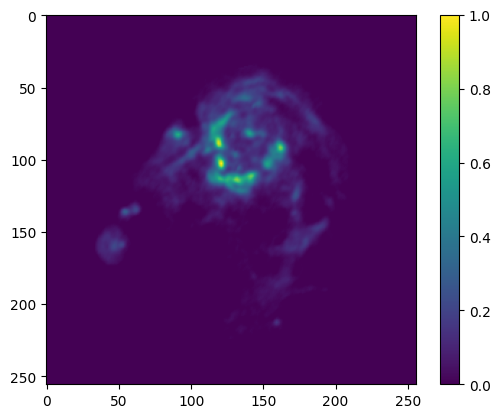

In [9]:

plt.figure()
plt.imshow(to_numpy(torch_img))
plt.colorbar()
plt.show()


In [10]:

# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by likelihood, stored in likelihood.beta

# Define real prox
cvx_set_prox_op = qai.operators.RealProx_torch()

In [11]:
wavs_list = ["db1", "db2", "db3", "db4", "db5", "db6", "db7", "db8", "self"]
levels = 4
reg_param = 1e2

# Define the wavelet dict
# Define the l1 norm with dict psi
psi = qai.operators.DictionaryWv_torch(wavs_list, levels, shape=torch_img.shape)
reg_prox_op = qai.operators.L1Norm_torch(1.0, psi, op_to_coeffs=True)
reg_prox_op.gamma = reg_param

In [12]:
# Compute stepsize
alpha = 0.98 / likelihood.beta

In [13]:

# Run the optimisation
x_hat, diagnostics = qai.optim.FISTA_torch(
    x_init,
    options=options,
    likelihood=likelihood,
    cvx_set_prox_op=cvx_set_prox_op,
    reg_prox_op=reg_prox_op,
    alpha=alpha,
    tau=alpha,
    viewer=None,
)

Running FISTA algorithm
[Forward Backward] 0 out of 15000 iterations, tol = 4.02e-01
[Forward Backward] converged in 75 iterations


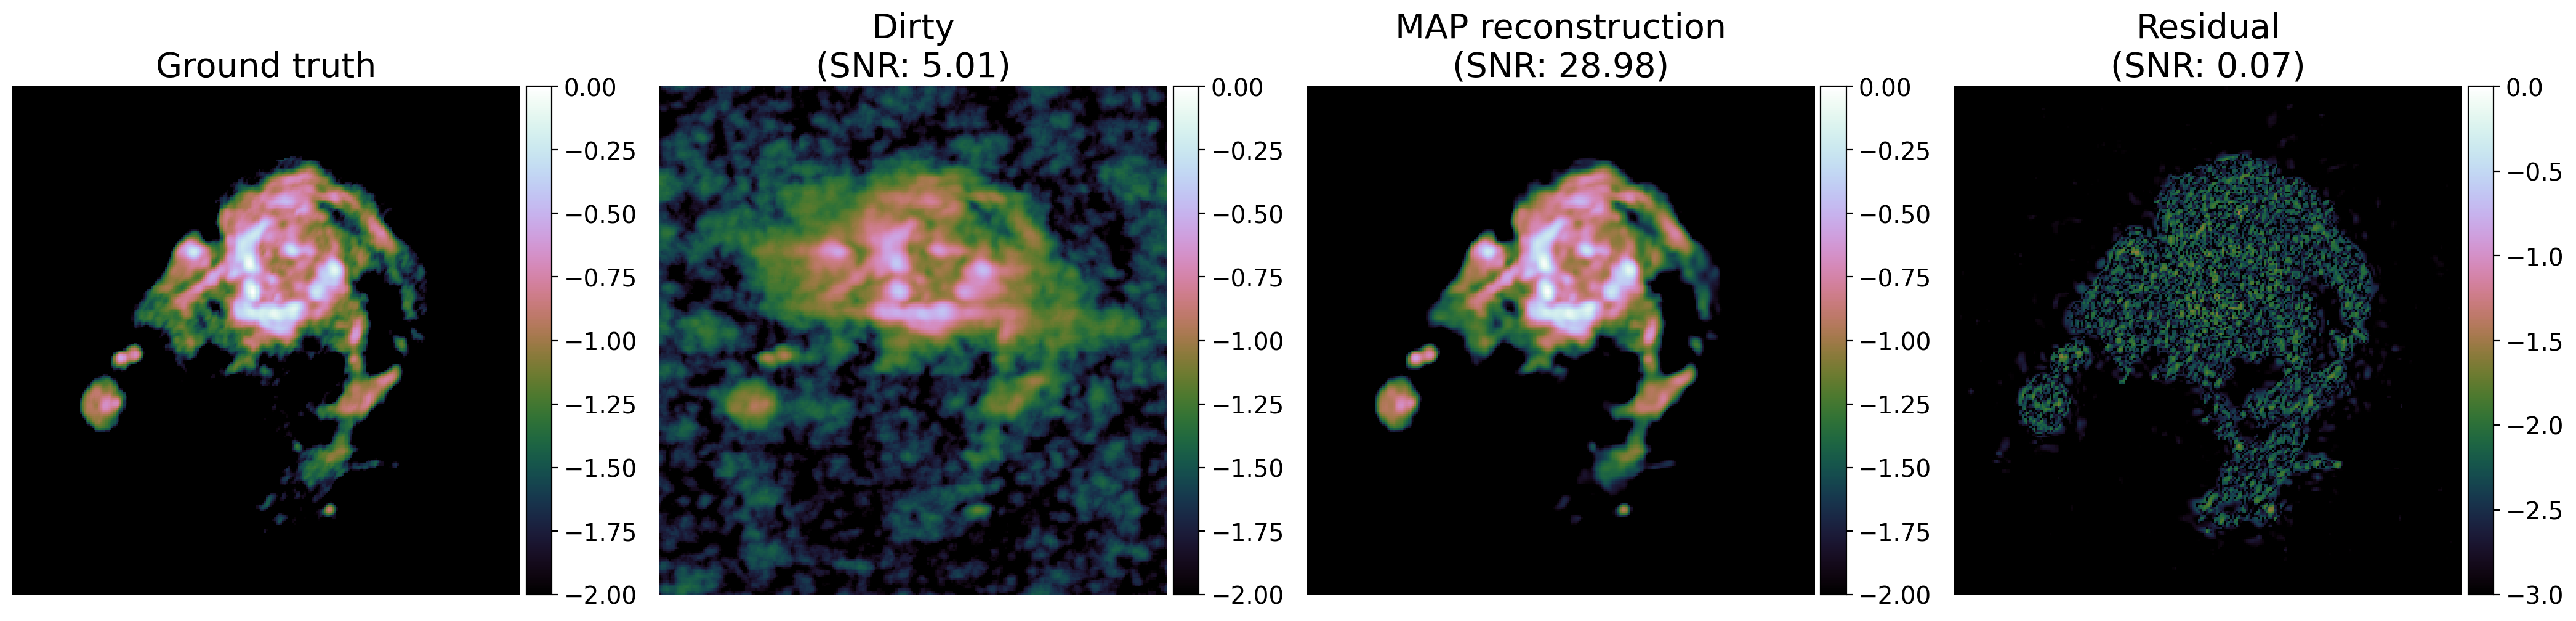

In [14]:
# Convert to numpy
np_x_init = to_numpy(x_init)
x_map = x_hat.clone()
x_gt = np.copy(x)
np_x_gt = np.copy(x)
np_x_map = to_numpy(x_map)


# Need to replace zero values with veery small numbers for the log plots
np_x_gt[np_x_gt == 0] = np.random.rand(np.sum(np_x_gt == 0)) * 1e-7

images = [np_x_gt, np_x_init, np_x_map, np_x_gt - np.abs(np_x_map)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(26, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    if i > 0:
        stats_str = "\n(SNR: {})".format(
            round(qai.utils.eval_snr(x, images[i]), 2),
        )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")
plt.show()

In [15]:

wavelet_dict = DictionaryWv_torch(
    wavs=["db2", "db4", "self"],
    levels=4,
    mode="periodic",
    shape=torch_img.shape
)


In [16]:
coeff_list = wavelet_dict.dir_op(torch_img.clone())

In [17]:
recon_img_list = wavelet_dict.adj_op(coeff_list)

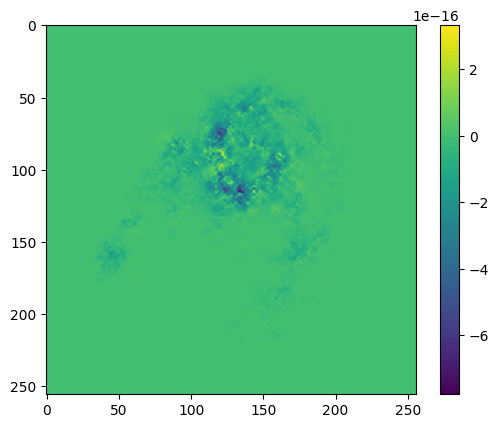

In [18]:
plt.figure()
plt.imshow(to_numpy(torch_img - recon_img_list))
plt.colorbar()
plt.show()


In [19]:
wavs_list = ["db2", "db4", "self"]
levels = 3
reg_param = 1e2

# Define the wavelet dict
# Define the l1 norm with dict psi
psi = DictionaryWv_torch(wavs_list, levels, shape=torch_img.shape)
reg_prox_op = L1Norm_torch(1.0, psi, op_to_coeffs=True)
reg_prox_op.gamma = reg_param

In [20]:


coeff_list = reg_prox_op.dir_op(torch_img.clone())

recon_img = reg_prox_op.adj_op(coeff_list)

# plt.figure()
# plt.imshow(to_numpy(torch_img - recon_img))
# plt.colorbar()
# plt.show()


In [21]:
tau = 1e-5
coeff_list = reg_prox_op.dir_op(torch_img.clone())

new_coeffs = reg_prox_op.prox(coeff_list, tau)

fun_value = reg_prox_op.fun(coeff_list)
